In [1]:
import sys
print(sys.version)

3.6.8 |Anaconda, Inc.| (default, Dec 29 2018, 19:04:46) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]


In [114]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, StratifiedKFold
from sklearn.utils import shuffle
from sklearn.cluster import DBSCAN
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt
from matplotlib import pyplot
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sns.set(style="ticks", color_codes=True)

from hpsklearn import HyperoptEstimator, ada_boost, gradient_boosting, random_forest, extra_trees, xgboost_classification
from hyperopt import tpe
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from xgboost import XGBClassifier
import xgboost as xgb
import time
import warnings

In [3]:
print('pandas version:', pd.__version__)

pandas version: 0.25.0


Table of Content
1. [Goal of This Project](#section1)
2. [Train-Test Split](#section2)
3. [Exploratory Data Analysis (EDA)](#section3)
4. [Preprocessing](#section4)
5. [Modeling](#section5)
6. [Error Analysis](#section6)
7. [Feature Selection](#section7)
8. [Reflection](#section8)

<a id='#section1'></a>
### 1. Goal of This Project

> to build a ML model that predicts the Diagnosis (DX), based on symptoms and other factors.

<a id='#section2'></a>
### 2. Train-Test split

> Following the golden rule of machine learning, I will set 30% data aside as a test set and keep 70% as training. Exploratory data analysis will be performed on the training data only.

In [4]:
data_table = pd.read_csv('../data/data_challenge.csv', index_col= 0)

In [5]:
np.random.seed(123)
shuffled_data_table = shuffle(data_table)

> Inspect the dimension of this data set.

In [6]:
shuffled_data_table.shape

(71662, 6)

In [7]:
target_index = round(shuffled_data_table.shape[0]*0.70)
training_data = shuffled_data_table[:target_index]
test_data = shuffled_data_table[target_index:]

In [8]:
training_data.shape

(50163, 6)

In [9]:
test_data.shape

(21499, 6)

<a id='#section3'></a>
### 3. Exploratory Data Anlysis (EDA)

In [10]:
training_data.head(6)

,DX,AGE,MONTH,SEX,Absent,Present
10356,c_0608,0.0,3,1,NaN,"s_0906, s_0084, s_0400, s_0097, s_0309, s_0180"
34268,c_0036,75.0,3,0,"s_0911, s_0070, s_0400, s_0136, s_0242, s_0078...","s_0553, s_1050, s_0246, s_2734, s_2755, s_0533..."
5939,c_0608,16.0,2,1,"s_0553, s_2740","s_0400, s_0309, s_0084, s_0826, s_0180"
65521,c_0608,0.0,9,0,"s_0106, s_0136, s_0002, s_0542, s_0837, s_0084...","s_0443, s_0363, s_2734"
59578,c_0608,16.0,3,1,"s_0070, s_0106, s_1050, s_0400, s_0242, s_0120...","s_0445, s_0478, s_0084"
8533,c_0273,28.0,9,1,"s_1611, s_0120, s_0542, s_2563","s_1211, s_0256"


In [11]:
training_data.describe()

,AGE,MONTH,SEX
count,50163.000000,50163.000000,50163.000000
mean,32.348564,6.205590,0.410243
std,20.144386,3.529732,0.491883
min,0.000000,1.000000,0.000000
25%,19.000000,3.000000,0.000000
50%,32.000000,6.000000,0.000000
75%,45.000000,9.000000,1.000000
max,161.000000,12.000000,1.000000


> `NaN` values seem to be present in this data set.

**Inspect NaN**

> Count the numbers of `NaN` in each column.

In [12]:
training_data.isnull().sum()

DX            0
AGE           0
MONTH         0
SEX           0
Absent     5133
Present    3691
dtype: int64

> Calculate the percent of missing values for `Absent` symptoms.

In [13]:
training_data.isnull().sum()[4]/training_data.shape[0]

0.10232641588421745

> Calculate the percent of missing values for `Present` symptoms.

In [14]:
training_data.isnull().sum()[5]/training_data.shape[0]

0.07358012878017663

> The `Absent` symptoms feature has roughly 10% of its data missing while the `Present` symptoms feature has 7% of its data missing. Test data should have `NaN` as well.

> I consider removing the rows with `NaN` a naive approach that will result in lost of valuable information because `age`, `month` and `sex` are still valuable features in the same row. The `age`, `month` and `sex` features are complete in the data set and can still be leveraged to buuld a ML model. 

> One strategy to handle `NaN` is to apply multiple imputation (`sklearn`: `IterativeImputer`) or simple imputation (`sklearn`: `SimpleImputer`) to fill the blanks. Since the `Absent` and `Present` symptoms are essentially categorical. When I preprocess the `Absent` and `Present` symptoms using one-hot encoding, I will make `NaN` as a feature. 

> Using `NaN` as a feature is inspired by Rohan's hint: '"Keep in mind that there may other potential symptoms the patient was never asked about, which are neither “present” nor “absent”.'

**Inspect DX**

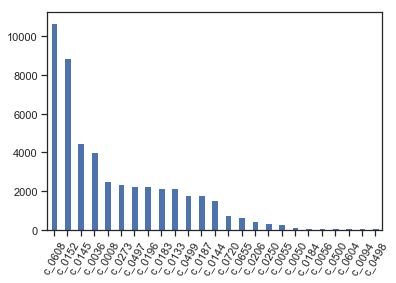

In [15]:
training_data['DX'].value_counts().plot(kind='bar')
plt.xticks(rotation=60)
plt.show()

In [16]:
training_data['DX'].unique().shape

(25,)

> There are 25 diagonses (25 labels) present in this data set.

In [17]:
training_data['DX'].value_counts()/training_data['DX'].count()

c_0608    0.213424
c_0152    0.176684
c_0145    0.089668
c_0036    0.080518
c_0008    0.050495
c_0273    0.047346
c_0497    0.044953
c_0196    0.044934
c_0183    0.043060
c_0133    0.043040
c_0499    0.036003
c_0187    0.035365
c_0144    0.030999
c_0720    0.015230
c_0655    0.013476
c_0206    0.009429
c_0250    0.006838
c_0055    0.005801
c_0050    0.003030
c_0184    0.001954
c_0056    0.001834
c_0500    0.001615
c_0604    0.001555
c_0094    0.001515
c_0498    0.001236
Name: DX, dtype: float64

> We have a class imbalance issue in "DX". 'c_0608' accounts for 21% of the diagnosis and 'c_0152' accounts for 18% of the diagnosis.

**Inspect AGE**

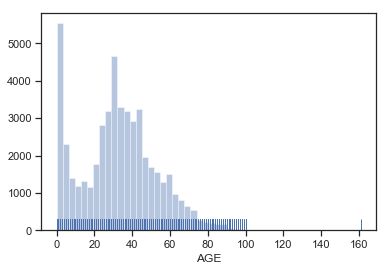

In [18]:
sns.distplot(training_data['AGE'], kde=False, rug=True)

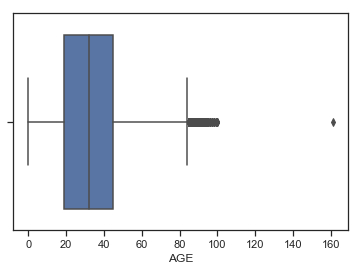

In [19]:
sns.boxplot(x=training_data['AGE'])

> It appears that this patient of age 161 is an outlier. This outlier may be a result of data entry error because the oldest human on 2018 Guinness World Record is 112 years old and he lives in Japan.

> Possibility 1: It was meant to be 16 years old instead of 161.

> Possibility 2: It was meant to be 61 years old instead of 161.

> Possibility 3: It was meant to be another age but not 16, 61 or 161 years old.

> I will use DBSCAN to try to identify outlier's age group.

In [20]:
training_data_age_outlier = pd.DataFrame(training_data, columns = ['AGE', 'MONTH', 'SEX'])


# ref: https://www.mikulskibartosz.name/outlier-detection-with-scikit-learn/
outlier_detection = DBSCAN(
  eps = 20,
  metric="euclidean",
  min_samples = 12,
  n_jobs = -1)
clusters = outlier_detection.fit_predict(training_data_age_outlier)

In [21]:
clusters

array([0, 0, 0, ..., 0, 0, 0])

In [22]:
cmap = cm.get_cmap('Accent')

In [23]:
cmap = cm.get_cmap('Accent')

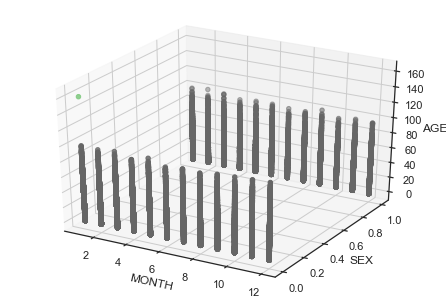

In [24]:
fig = pyplot.figure()
ax = Axes3D(fig)
ax.set_xlabel('MONTH')
ax.set_ylabel('SEX')
ax.set_zlabel('AGE')
ax.scatter(training_data_age_outlier['MONTH'], 
           training_data_age_outlier['SEX'], 
           training_data_age_outlier['AGE'],
           c = clusters,
          cmap = cmap)
pyplot.show()

In [25]:
training_data_age_vs_month = pd.DataFrame(training_data, columns = ['AGE', 'MONTH'])

outlier_detection2 = DBSCAN(
  eps = 20,
  metric="euclidean",
  min_samples = 12,
  n_jobs = -1)
clusters2 = outlier_detection2.fit_predict(training_data_age_vs_month)

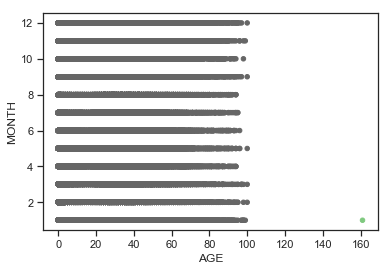

In [26]:
training_data_age_vs_month.plot.scatter(
  x = "AGE",
  y = "MONTH",
  c = clusters2,
  cmap = cmap,
  colorbar = False
)

In [27]:
training_data_age_vs_sex = pd.DataFrame(training_data, columns = ['AGE', 'SEX'])

outlier_detection3 = DBSCAN(
  eps = 20,
  metric="euclidean",
  min_samples = 12,
  n_jobs = -1)
clusters3 = outlier_detection3.fit_predict(training_data_age_vs_sex)

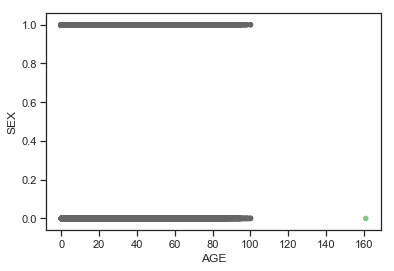

In [28]:
training_data_age_vs_sex.plot.scatter(
  x = "AGE",
  y = "SEX",
  c = clusters3,
  cmap = cmap,
  colorbar = False
)

> These visuals do not help me identify the proper age group of this outlier. I need to do clustering again after I encode the `Present` and `Absent` symptoms as features.

**Inspect MONTH**

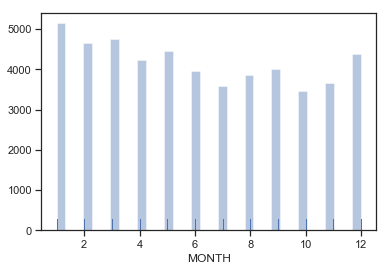

In [29]:
sns.distplot(training_data['MONTH'], kde=False, rug=True)

> Months seem to be more uniformly distributed.

**Inspect SEX**

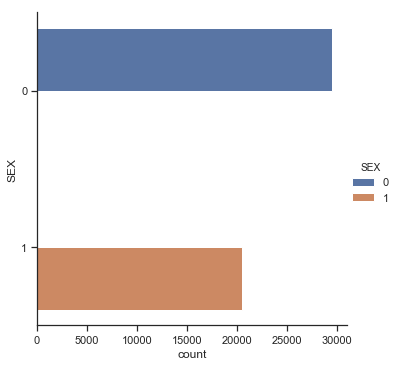

In [30]:
sns.catplot(y='SEX', 
            hue='SEX',
           kind='count',
           data=training_data)

> There are more female patients in this data set.

**Inspect Absent symptoms**

> First, fill `NaN` with string then turn `Absent` into dummy variables and include `NaN` as a feature.

In [31]:
training_data.fillna('missing', inplace=True)

/anaconda3/envs/style-search/lib/python3.6/site-packages/pandas/core/frame.py:4239: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  **kwargs


In [32]:
# ref: https://stackoverflow.com/questions/46867201/converting-pandas-column-of-comma-separated-strings-into-dummy-variables
training_data_encode = training_data['Absent'].str.get_dummies(sep=',').rename(lambda x: 'abs_' + x, axis='columns')

In [33]:
training_data_encode_sum = pd.DataFrame(data=training_data_encode.sum(), columns=['count'])

In [34]:
training_data_encode_sum.head()

,count
abs_ s_0002,10694
abs_ s_0003,49
abs_ s_0004,44
abs_ s_0006,10
abs_ s_0012,1


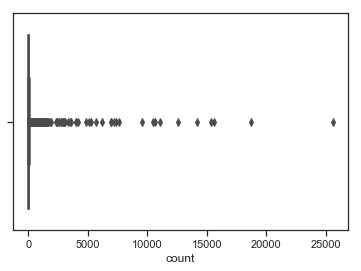

In [35]:
sns.boxplot(x=training_data_encode_sum['count'])

In [36]:
training_data_encode_sum.describe()

,count
count,901.000000
mean,384.990011
std,1766.193744
min,1.000000
25%,2.000000
50%,8.000000
75%,50.000000
max,25612.000000


> More than 50% of symptoms in `Absent` have appeared at least 8 times in the data set.

In [37]:
training_data_encode_sum.sort_values(by='count', ascending=False).head(10)

,count
abs_ s_0180,25612
abs_ s_0542,18726
abs_ s_0837,15640
abs_ s_0022,15396
abs_ s_0084,14202
abs_ s_0553,12581
abs_ s_1266,11075
abs_ s_0002,10694
abs_s_0070,10492
abs_ s_0242,9534


> These symptoms above are the ten most commonly `Absent` symptoms.

**Inspect Present symptoms**

> I will follow the same procedure as the `Absent` symptoms. Convert the `Present` symptoms to dummy variables.

In [38]:
# ref: https://stackoverflow.com/questions/46867201/converting-pandas-column-of-comma-separated-strings-into-dummy-variables
training_data_encode2 = training_data['Present'].str.get_dummies(sep=',').rename(lambda x: 'prs_' + x, axis='columns')

In [39]:
training_data_encode_sum2 = pd.DataFrame(data=training_data_encode2.sum(), columns=['count'])

In [40]:
training_data_encode_sum2.head(6)

,count
prs_ s_0002,693
prs_ s_0004,26
prs_ s_0006,10
prs_ s_0014,1
prs_ s_0019,1
prs_ s_0022,2875


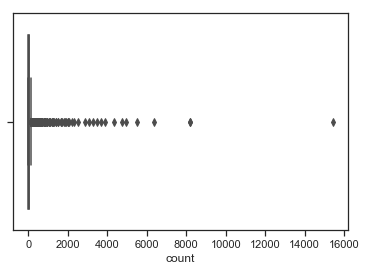

In [41]:
sns.boxplot(x=training_data_encode_sum2['count'])

In [42]:
training_data_encode_sum2.describe()

,count
count,1098.000000
mean,168.457195
std,764.949914
min,1.000000
25%,2.000000
50%,8.500000
75%,52.750000
max,15426.000000


> More than 50% of symptoms in `Present` have appeared at least 8.5 times in the data set.

In [43]:
training_data_encode_sum2.sort_values(by='count', ascending=False).head(10)

,count
prs_ s_0084,15426
prs_ s_0180,8198
prs_ s_0445,8171
prs_s_0445,6353
prs_ s_0826,5494
prs_ s_0309,4933
prs_ s_2734,4759
prs_ s_2194,4354
prs_s_0136,3884
prs_missing,3691


> These symptoms above are the ten most commonly `Present` symptoms. Notice that `NaN` which was replaced by string `missing` was the 10th most common `Present` symptoms. Seeing `missing` as No. 10 most frequent `Present` symptoms implies that many symptoms are not recorded in `Present` symptoms.

**Check Duplicate Entries**

In [44]:
# ref: https://thispointer.com/pandas-find-duplicate-rows-in-a-dataframe-based-on-all-or-selected-columns-using-dataframe-duplicated-in-python/
training_data[training_data.duplicated(keep='first')].shape

(101, 6)

> There are 101 duplicated rows. I will make the following assumption:

> These duplicated rows are not data-entry errors. These duplicated are patients who experience the same `Absent` and `Present` symptoms while happened to visit a clinic/hospital during the same month. Their age and gender are the same. 

> My assumptions are based on the following reasons:

1. Other types of patient identifiers are not provided in this data set so I cannot assume that the entries are duplicated.

2. Some diseases (ie. flu) are seasonal and may have similar symptoms. Specific age groups (Children and seniors) are more susceptible to certain diseases. 

> A note on feature scaling: 

> Feature scaling will not be necessary because I will be using tree-based models which are invariant to feature scaling.

ref: https://stats.stackexchange.com/questions/244507/what-algorithms-need-feature-scaling-beside-from-svm

<a id='#section4'></a>
### 4. Preprocessing

> To ensure that the dimensions of training and test sets are consistent, I will preprocess the original data table again then split it into training and test sets.

> Step 1: replace `NaN` with the string `missing`.

In [45]:
shuffled_data_table.fillna('missing', inplace=True)

> Step 2: create dummy variables.

In [46]:
shuffled_data_table_encode = shuffled_data_table['Absent'].str.get_dummies(sep=',').rename(lambda x: 'abs_' + x, axis='columns')
shuffled_data_table_encode2 = shuffled_data_table['Present'].str.get_dummies(sep=',').rename(lambda x: 'prs_' + x, axis='columns')

> Step 3: join the dataframes.

In [47]:
full_data_table = shuffled_data_table.join(shuffled_data_table_encode, how='left')
full_data_table = full_data_table.join(shuffled_data_table_encode2, how='left')

> Step 4: drop the original `Absent` and `Present` symptoms columns.

In [48]:
full_data_table = full_data_table.drop(labels=['Absent', 'Present'], axis=1)

> Step 5: Perform the same train-test split I did in section 2.

In [49]:
train_df = full_data_table[:target_index]
test_df = full_data_table[target_index:]

In [50]:
train_df.shape

(50163, 2123)

In [51]:
train_df.head()

,DX,AGE,MONTH,SEX,abs_ s_0002,abs_ s_0003,abs_ s_0004,abs_ s_0006,abs_ s_0012,abs_ s_0013,...,prs_s_2738,prs_s_2739,prs_s_2740,prs_s_2741,prs_s_2742,prs_s_2743,prs_s_2754,prs_s_2755,prs_s_2768,prs_s_2770
10356,c_0608,0.0,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
34268,c_0036,75.0,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5939,c_0608,16.0,2,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
65521,c_0608,0.0,9,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59578,c_0608,16.0,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [52]:
test_df.shape

(21499, 2123)

> The new training and test sets have the same number of rows as the previous un-dummified sets. Their columns have the same dimension now. By inspecting the dimensions of the new training and test sets, I have successfully encoded the `Absent` and `Present` symptoms.

<a id='#section5'></a>
### 5. Modeling

> Part A: use `hyperopt` library

> First, I will create a label array.

In [53]:
# create label array 
train_df_dx_cat = pd.factorize(train_df['DX'])[0]+1
y = train_df_dx_cat
y.shape

(50163,)

In [75]:
np.unique(y)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25])

In [54]:
# create a test label array as well
test_df_dx_cat = pd.factorize(test_df['DX'])[0]+1
y_test = test_df_dx_cat
y_test.shape

(21499,)

In [55]:
# create feature array 

X = train_df.drop(['DX'], axis=1).values
X.shape

(50163, 2122)

In [56]:
# create a test feature array as well


X_test = test_df.drop(['DX'], axis=1).values
X_test.shape

(21499, 2122)

> I will take one small set out of training data using stratified k-fold. Stratified k-fold will handle class imbalance so I do not have to do bootstrap sampling.

In [95]:
skf = StratifiedKFold(n_splits=2, random_state=10)
skf.get_n_splits(X, y)
print(skf)

StratifiedKFold(n_splits=2, random_state=10, shuffle=False)


> I only need one set so I will run this for loop only once.

In [96]:
for train_index, val_index in skf.split(X, y):
    print("TRAIN:", train_index, "VAL:", val_index)
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    break

TRAIN: [22490 23548 23597 ... 50160 50161 50162] VAL: [    0     1     2 ... 27045 29078 29152]


In [97]:
X_train.shape

(25076, 2122)

In [98]:
y_train.shape

(25076,)

> Now, use the `hyperopt` library to search for the best model with the best hyperparameters.

In [99]:
# list of classifiers: random_forest, extra_trees

clf = hp.pchoice( 'initial', 
          [ ( 0.5, random_forest('initial.random_forest') ),
            ( 0.5, extra_trees('initial.extra_trees') ) ] )

estim = HyperoptEstimator( classifier=clf, algo=tpe.suggest, trial_timeout=300)

In [100]:
estim.fit( X_train, y_train )

100%|██████████| 1/1 [00:19<00:00, 19.05s/it, best loss: 0.4244417862838915]


In [101]:
print( estim.score( X_val, y_val ) )

0.5665085502451469


In [102]:
print( estim.best_model() )

{'learner': RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=None, max_features=0.13586036204220875,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=3,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=39, n_jobs=1, oob_score=False, random_state=4,
            verbose=False, warm_start=False), 'preprocs': (StandardScaler(copy=True, with_mean=False, with_std=False),), 'ex_preprocs': ()}


> The validation score does not look promising but it is a start. I will use Random Forest instead of ExtraTreesClassifier.

> Next, I will build a XGBoost classifier using Stratified k-fold cross validation.

ref: https://www.kaggle.com/henrylidgley/xgboost-with-hyperopt-tuning
```
def objective(space):

    warnings.filterwarnings(action='ignore', category=DeprecationWarning)
    classifier = xgb.XGBClassifier(n_estimators = space['n_estimators'],
                            max_depth = int(space['max_depth'])
                            #learning_rate = space['learning_rate'],
                            #gamma = space['gamma'],
                            #min_child_weight = space['min_child_weight'],
                            #subsample = space['subsample'],
                            #colsample_bytree = space['colsample_bytree']
                            )
    
    classifier.fit(X_train, y_train)
    
    # Applying k-Fold Cross Validation
    from sklearn.model_selection import cross_val_score
    accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 2)
    CrossValMean = accuracies.mean()

    print("CrossValMean:", CrossValMean)

    return{'loss':1-CrossValMean, 'status': STATUS_OK }
```

```
space = {
    'max_depth' : hp.choice('max_depth', range(10, 300, 10)),
     'learning_rate' : hp.quniform('learning_rate', 0.01, 0.5, 0.01),
    'n_estimators' : hp.choice('n_estimators', range(20, 250, 10))
     'gamma' : hp.quniform('gamma', 0, 0.50, 0.01),
     'min_child_weight' : hp.quniform('min_child_weight', 1, 10, 1),
     'subsample' : hp.quniform('subsample', 0.1, 1, 0.01),
     'colsample_bytree' : hp.quniform('colsample_bytree', 0.1, 1.0, 0.01)
        }

trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50,
            trials=trials)

print("Best: ", best)
```

> Hyperparameter tuning for `xgboost` and `ada_boost` took way too long. For the interest for time, I will choose Random Forest Classifier as my final model and perform a full 10-fold cross validation.

In [106]:
classifier_pipeline = make_pipeline(preprocessing.StandardScaler(copy=True, with_mean=False, with_std=False),
                                    RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
                                        max_depth=None, max_features=0.13586036204220875,
                                        max_leaf_nodes=None, min_impurity_decrease=0.0,
                                        min_impurity_split=None, min_samples_leaf=3,
                                        min_samples_split=2, min_weight_fraction_leaf=0.0,
                                        n_estimators=39, n_jobs=1, oob_score=False, random_state=4,
                                        verbose=False, warm_start=False))

In [108]:
scores = cross_val_score(classifier_pipeline, X, y, cv=10)

In [109]:
scores.mean()

0.5786545178598447

> The stratified 10-fold cross-validation gives a slightly higher score which is a better reflection of how the model does.

> Now, I will retrain the model with the full training data and predict on the test data.

In [120]:
rf_clf = RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
                                        max_depth=None, max_features=0.13586036204220875,
                                        max_leaf_nodes=None, min_impurity_decrease=0.0,
                                        min_impurity_split=None, min_samples_leaf=3,
                                        min_samples_split=2, min_weight_fraction_leaf=0.0,
                                        n_estimators=39, n_jobs=1, oob_score=False, random_state=4,
                                        verbose=False, warm_start=False)

In [121]:
rf_clf.fit(X, y)

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=None, max_features=0.13586036204220875,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=3,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=39, n_jobs=1, oob_score=False, random_state=4,
            verbose=False, warm_start=False)

In [122]:
rf_clf.score(X_test, y_test)

0.1983813200613982

> The test score is very low.

<a id='#section1'></a>
### 6. Error Analysis

In [113]:
y_pred = rf_clf.predict(X_test)

> use weighted f1-score to account for class imbalance.

In [115]:
precision_recall_fscore_support(y_pred=y_pred, y_true=y_test, average='weighted')

/anaconda3/envs/style-search/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


(0.19141859697332428, 0.1983813200613982, 0.1852501857101185, None)

My model seems to overfit on the training data because its cross validation score is much higher than the test score.

<a id='#section7'></a>
### 7. Feature Selection

> The features selected from the model will not be very indicative because the model performs poorly.

> Inspect the features selected by Random Forest Classifier.

In [125]:
feature_importances = pd.DataFrame(rf_clf.feature_importances_,
                                   index = train_df.drop(['DX'], axis=1).columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

In [126]:
feature_importances.head(10)

,importance
AGE,0.103902
prs_s_0445,0.060558
prs_ s_0084,0.059835
prs_s_0136,0.041898
prs_ s_0445,0.038265
MONTH,0.036372
prs_ s_1316,0.033140
prs_ s_2563,0.026811
prs_ s_0136,0.013114
SEX,0.011379


> The chart is a list of top 10 features used in the Random Forest Classifiers. `AGE` seems to have the largest importance. This model seems to focus more on the `MONTH`, `SEX` and specific `Present` symptoms.

<a id='#section8'></a>
### 8. Reflection

**With exploratory data analysis, I learned that:**

1. The data set was clean. 

2. I identified that one outlier in the `AGE` feature which was possiblity due to be a data entry error.  

3. I made the assumption that the duplicated rows were not a mistake in data entry. I assumed that they were different patients with same `AGE`, `SEX`, `Absent`, and `Present` symptoms which led to the same `DX`.

4. There was an class imbalance issue. There were 25 class labels but `c_0608` and `c_0152` accounted for 38% of the whole diangoses. I tried to use stratified k-fold cross validation to address this class imbalance.

**What I would have done if I had more time:**

To address class imbalance:

1. use focal loss technique. [ref](https://www.dlology.com/blog/multi-class-classification-with-focal-loss-for-imbalanced-datasets/)

2. upsample minority class or downsample majority class.

**For modeling, my model did not perform well possibly due the following:**

1. I did not select the best models to run `hyperopt`.

2. `trial_timeout=300` in `hyperopt` was too short to exploration the hyperparameter space sufficiently to find a well-performing optimum.

3. The computation power of my MacBook Air was limited so I used `hyperopt` on a 2-fold cross-validation.

**What I would have done if I had more time:**

To address poor model performance:

I should train on AWS EC2 using GPU so I can:

1. include more models such as `XGBoost` and `multiclass logistic regression` in the `hyperopt` search.

2. increase `trail_timeout` value so that the hyperparameter space can be sufficiently explored.

3. specify the range of hyperparameters to explore to reduce tuning time.

4. increase the `n_estimators` of the Random Forest to reduce overfitting.

5. explore neural network models

**For feature selection, I did the following:**

- I inspected the key features of my under-performing model with the `sklearn` `feature_importances_`. Since the model underperformed, the top ten features selected by the model would not have much value.

**What I would have done if I had more time:**

1. use Elastic Net(L1/L2) regression to select features.

2. use Forward Selection to select features. [ref](https://towardsdatascience.com/feature-importance-and-forward-feature-selection-752638849962)

**Overall:**

It was a great learning experience! Thank you for offering me this data challenge!
 